In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import xgboost as xgb

/home/jiashen/env3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
train = pd.read_csv('train_fillna_lsby.csv')
test = pd.read_csv('test_fillna_lsby.csv')

In [5]:
del train['apartment_name']
del train['Average_Yr']
del test['apartment_name']
del test['Average_Yr']

In [6]:
col = list(test.columns)[2:]

In [7]:
label = train['price_doc']*0.95+10

In [8]:
dtrain = xgb.DMatrix(train[col],label)
dtest = xgb.DMatrix(test[col])

In [9]:
params = {
    'eta': 0.05, ## Try 0.01,3,5
    'max_depth': 5,## Try 4,5,6
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

[0]	train-rmse:7.7953e+06	test-rmse:7.79767e+06
[50]	train-rmse:2.40559e+06	test-rmse:2.75498e+06
[100]	train-rmse:2.08483e+06	test-rmse:2.58141e+06
[150]	train-rmse:1.96973e+06	test-rmse:2.54806e+06
[200]	train-rmse:1.88523e+06	test-rmse:2.52962e+06
[250]	train-rmse:1.82009e+06	test-rmse:2.51979e+06
[300]	train-rmse:1.76227e+06	test-rmse:2.51391e+06
[350]	train-rmse:1.71047e+06	test-rmse:2.51083e+06
[400]	train-rmse:1.66229e+06	test-rmse:2.50735e+06
Performance does not improve from 407 rounds


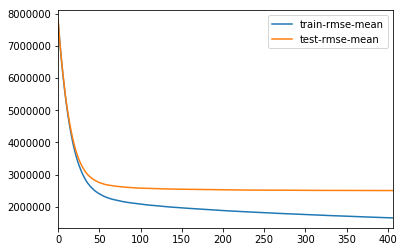

In [10]:
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [ ]:
#[0]	train-rmse:7.7958e+06	test-rmse:7.80037e+06
#[50]	train-rmse:2.39694e+06	test-rmse:2.76631e+06
#[100]	train-rmse:2.07912e+06	test-rmse:2.59791e+06
#[150]	train-rmse:1.97156e+06	test-rmse:2.56523e+06
#[200]	train-rmse:1.89038e+06	test-rmse:2.54726e+06
#[250]	train-rmse:1.82037e+06	test-rmse:2.53597e+06
#[300]	train-rmse:1.76422e+06	test-rmse:2.53101e+06
#[350]	train-rmse:1.7127e+06	test-rmse:2.52498e+06
#Performance does not improve from 372 rounds

In [11]:
model = xgb.train(params,dtrain,num_boost_round=len(xgb_cvalid))

In [12]:
def get_feature_importance(model):
    Importance = model.get_fscore()
    Importance = list(Importance.items())
    Feature= []
    Score = []
    for each in Importance:
        Feature.append(each[0])
        Score.append(each[1])
    df = pd.DataFrame({'Feature':Feature,'Score':Score}).sort_values(by=['Score'],ascending=[0])
    return df    

In [29]:
def plot_importance(model):
    FImportance = get_feature_importance(model).iloc[0:50,]
    plt.figure()
    FImportance.plot(kind='barh', x='Feature', y='Score', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.show()

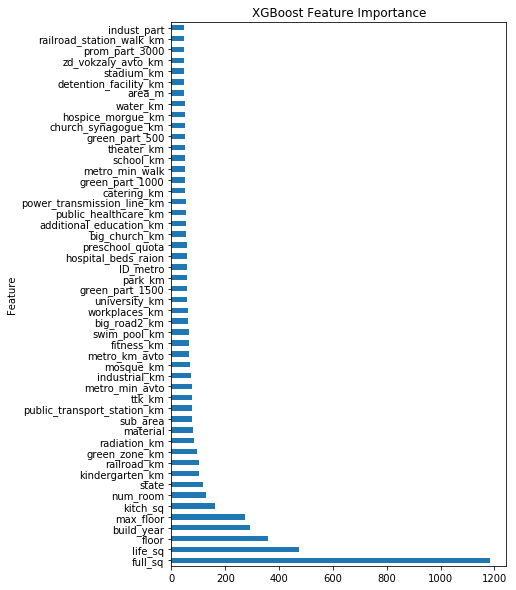

In [30]:
plot_importance(model)

In [14]:
prediction = model.predict(dtest)
sub = pd.DataFrame({'id':test['id'],'price_doc':prediction})

In [15]:
sub.to_csv('xgb_0.95label_life_sq_build_year_NA_filled.csv',index=False)